In [1]:
import sys

sys.path.insert(0, '..')

import os
import requests
import json
from tempfile import mkdtemp
import libsbml
import amici
import os
from biosimulator_processes.utils import prepare_single_ode_process_document
from biosimulator_processes.data_model.compare_data_model import ODEComparisonDocument, DocumentFactory
from biosimulator_processes import CORE
from process_bigraph import Composite, pp

CobraProcess registered successfully.
CopasiProcess registered successfully.
SmoldynProcess not available. Error: 
PLEASE NOTE: Smoldyn is not correctly installed on your system which prevents you from using the SmoldynProcess. Please refer to the README for further information on installing Smoldyn.
TelluriumProcess registered successfully.
AmiciProcess registered successfully.


In [10]:
"""TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:

{('emitter',): [{
    'copasi': [
        {
            'floating_species_concentrations': {
                'plasminogen': 0.0,
                'plasmin': 0.0,
                'single intact chain urokinase-type plasminogen activator': 0.0,
                'two-chain urokinase-type plasminogen activator': 0.0,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0
        },
        ...
    ],
    'amici': [
        {
            'floating_species_concentrations': {
                'plasminogen': 1.1758171177387002e+16,
                'plasmin': 1096150505274.1506,
                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
                'two-chain urokinase-type plasminogen activator': 80249.33829510311,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0},
        },
       ...
    ]


"""

"TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:\n\n{('emitter',): [{\n    'copasi': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 0.0,\n                'plasmin': 0.0,\n                'single intact chain urokinase-type plasminogen activator': 0.0,\n                'two-chain urokinase-type plasminogen activator': 0.0,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0\n        },\n        ...\n    ],\n    'amici': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 1.1758171177387002e+16,\n                'plasmin': 1096150505274.1506,\n                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,\n                'two-chain urokinase-type plasminogen activator': 80249.33829510311,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0},\n        },\n 

In [2]:
# Step 1: Define the input parameters of the api method

biomodel_id = 'BIOMD0000000630'
model_fp = f'../biosimulator_processes/model_files/sbml/{biomodel_id}_url.xml'
species_context = 'concentrations'
species_port_name = f'floating_species_{species_context}'
species_store = [f'floating_species_{species_context}_store']
duration = 30
n_steps = 42
simulators = ['copasi', 'amici']

In [3]:
# Step 2: Define a helper composite maker

comparison_document = ODEComparisonDocument(
    simulators=simulators,
    duration=duration,
    num_steps=n_steps,
    model_filepath=model_fp)

comparison_document.composite

{'copasi_0': {'_type': 'process',
  'address': 'local:copasi',
  'config': {'model': {'model_source': '../biosimulator_processes/model_files/sbml/BIOMD0000000630_url.xml'}},
  'inputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'model_parameters': ['model_parameters_store'],
   'time': ['time_store'],
   'reactions': ['reactions_store']},
  'outputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'time': ['time_store']}},
 'amici_1': {'_type': 'process',
  'address': 'local:amici',
  'config': {'model': {'model_source': '../biosimulator_processes/model_files/sbml/BIOMD0000000630_url.xml'}},
  'inputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'model_parameters': ['model_parameters_store'],
   'time': ['time_store'],
   'reactions': ['reactions_store']},
  'outputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'time': ['time_store']}}

In [4]:
# Step 2a: Define one more amici process for demo purposes

comparison_document.add_single_process_to_composite(process_id='amici_2', simulator='amici')

comparison_document.composite

{'copasi_0': {'_type': 'process',
  'address': 'local:copasi',
  'config': {'model': {'model_source': '../biosimulator_processes/model_files/sbml/BIOMD0000000630_url.xml'}},
  'inputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'model_parameters': ['model_parameters_store'],
   'time': ['time_store'],
   'reactions': ['reactions_store']},
  'outputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'time': ['time_store']}},
 'amici_1': {'_type': 'process',
  'address': 'local:amici',
  'config': {'model': {'model_source': '../biosimulator_processes/model_files/sbml/BIOMD0000000630_url.xml'}},
  'inputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'model_parameters': ['model_parameters_store'],
   'time': ['time_store'],
   'reactions': ['reactions_store']},
  'outputs': {'floating_species_concentrations': ['floating_species_concentrations_store'],
   'time': ['time_store']}}

In [5]:
# Step 3: Add document to composition

ode_comparison_workflow = Composite(
    config={'state': comparison_document.composite},
    core=CORE)

2024-05-03 20:15:03.440 - amici.sbml_import - INFO - Finished importing SBML                         (3.66E-02s)


found a filepath


2024-05-03 20:15:03.487 - amici.sbml_import - INFO - Finished processing SBML observables            (4.34E-02s)
2024-05-03 20:15:03.491 - amici.sbml_import - INFO - Finished processing SBML event observables      (9.58E-07s)
2024-05-03 20:15:03.530 - amici.de_model - INFO - Finished computing xdot                            (4.90E-03s)
2024-05-03 20:15:03.537 - amici.de_model - INFO - Finished computing x0                              (3.07E-03s)
2024-05-03 20:15:03.550 - amici.de_model - INFO - Finished computing w                               (9.39E-03s)
2024-05-03 20:15:04.070 - amici.de_export - INFO - Finished generating cpp code                      (5.14E-01s)
2024-05-03 20:15:21.859 - amici.de_export - INFO - Finished compiling cpp code                       (1.78E+01s)


found a filepath


In [6]:
# Step 4: Run the comparison

ode_comparison_workflow.run(duration)

/Users/alex/Desktop/uchc_work/repos/biosimulator-processes/demos/../biosimulator_processes/processes/copasi_process.py:245: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Values for plasminogen in AmiciProcess: 0.0
Values for plasmin in AmiciProcess: 0.0
Values for single intact chain urokinase-type plasminogen activator in AmiciProcess: 0.0
Values for two-chain urokinase-type plasminogen activator in AmiciProcess: 0.0
Values for x in AmiciProcess: 0.0
Values for x-plasmin in AmiciProcess: 0.0
Values for plasminogen in AmiciProcess: 1.1758171177387002e+16
Values for plasmin in AmiciProcess: 1096150505274.1506
Values for single intact chain urokinase-type plasminogen activator in AmiciProcess: 2955755808974603.0
Values for two-chain urokinase-type plasminogen activator in AmiciProcess: 80249.33829510311
Values for x in AmiciProcess: 0.0
Values for x-plasmin in AmiciProcess: 0.0
Values for plasminogen in AmiciProcess: 1.7311483609242468e+16
Values for plasmin in AmiciProcess: 4126180180911.928
Values for single intact chain urokinase-type plasminogen activator in AmiciProcess: 4565981193830563.0
Values for two-chain urokinase-type plasminogen activator in

In [7]:
# Step 5: Gather the comparison results from the Process Bigraph Engine (workflow)

ode_comparison_results = ode_comparison_workflow.gather_results()

In [8]:
ode_comparison_results

{('emitter',): [{'floating_species_concentrations': {'plasminogen': 0.0,
    'plasmin': 0.0,
    'single intact chain urokinase-type plasminogen activator': 0.0,
    'two-chain urokinase-type plasminogen activator': 0.0,
    'x': 0.0,
    'x-plasmin': 0.0},
   'time': 0.0},
  {'floating_species_concentrations': {'plasminogen': 1.1758171177387002e+16,
    'plasmin': 1096150505274.1506,
    'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
    'two-chain urokinase-type plasminogen activator': 80249.33829510311,
    'x': 0.0,
    'x-plasmin': 0.0},
   'time': 2.0},
  {'floating_species_concentrations': {'plasminogen': 1.7311483609242468e+16,
    'plasmin': 4126180180911.928,
    'single intact chain urokinase-type plasminogen activator': 4565981193830563.0,
    'two-chain urokinase-type plasminogen activator': 2976560.37325531,
    'x': 0.0,
    'x-plasmin': 0.0},
   'time': 4.0},
  {'floating_species_concentrations': {'plasminogen': 2.26869588734145e+16,
   

In [9]:
# Step 6: Perform mean-squared-error on each simulator's output
# TODO: implement this.

In [ ]:
# Step 7: Return a pydantic-friendly ComparisonResult object for the REST api

In [2]:
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice)
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

boundary_condition = BoundaryCondition.OPEN
num_nodes = 5
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)
t = -1.0
u = 0.0
v = 5.0
lattice = line_lattice.uniform_parameters(uniform_interaction=t, uniform_onsite_potential=v)

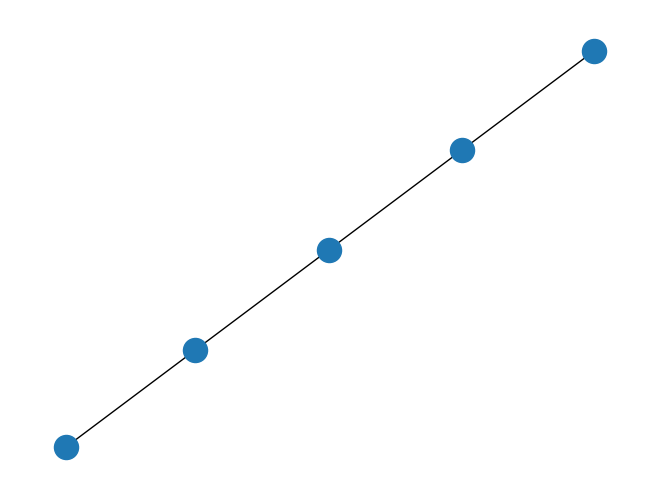

In [3]:
lattice.draw()

In [ ]:
fhm = FermiHubbardModel(
    line_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=u,
)

lmp = LatticeModelProblem(fhm)